In [277]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
# from models.POD import PODNonlinearModel
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results
from trainers.train import train_loop

from vecopsciml.operators.zero_order import Mx, My

In [278]:
from collections import Counter

In [279]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data/non_linear/non_linear_1000.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/non_linear')
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/non_linear/fourier_model')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_PATH)

Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear/fourier_model


In [280]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear/non_linear_1000.pkl


In [281]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [282]:
DEVICE = torch.device("cpu")

In [283]:
# Train data splitting in train/test
X = torch.tensor(dataset['X_train'], dtype=torch.float32).unsqueeze(1)
y = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(1)
K = torch.tensor(dataset['k_train'], dtype=torch.float32).unsqueeze(1)
f = torch.tensor(dataset['f_train'], dtype=torch.float32).unsqueeze(1)

X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

# Data processing and adequacy with our TensOps library
X_train = X_train.to(DEVICE)
X_test = X_test.to(DEVICE)

y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
y_test = TensOps(y_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
K_test = TensOps(K_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
f_test = TensOps(f_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

# Loading and processing validation data
X_val = torch.tensor(dataset['X_val'], dtype=torch.float32).unsqueeze(1)
y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

In [284]:
def modes_base(data, n_modes):

    # FFT decomposition and obtain energy of each mode
    fft_data = torch.fft.fft2(data)
    energy = torch.abs(fft_data)
    energy_flattened = energy.flatten(1, 3)

    # Get the n_modes more energetic modes and their indices
    top_energetic = energy_flattened[:, :n_modes]

    # Create an empty template to include the modes
    filtered_modes = torch.zeros_like(energy, dtype=torch.complex64)
    filtered_modes.flatten(1, 3)[:, :n_modes] = fft_data.flatten(1, 3)[:, :n_modes]

    # Return the base with the 'n_modes' most energetic modes
    return filtered_modes

def reconstruct_data(coefficients_filtered):
    
    # Compute inverse FFT and reconstruct data
    reconstructed_data = torch.real(torch.fft.ifft2(coefficients_filtered))

    return reconstructed_data

In [285]:
num_modes = 90

_ = modes_base(data=y_train.values, n_modes=num_modes)
reconstructed_data = reconstruct_data(_)

In [286]:
# Predictive network architecture
input_shape = X_train[0].shape
predictive_layers = [20, 10, num_modes]
predictive_output = y_train.values[0].shape

# Explanatory network architecture
explanatory_input = Mx(My(y_train)).values[0].shape
explanatory_layers = [10, 10]
explanatory_output = Mx(My(f_train)).values[0].shape

# Other parameters
n_filters_explanatory = 5

In [287]:
import torch
import torch.nn as nn

from vecopsciml.utils import TensOps
from vecopsciml.operators.zero_order import Mx, My

class Encoder(nn.Module):

    def __init__(self, input_size, hidden_layer_1_size, hidden_layer_2_size, latent_space_size):
        super(Encoder, self).__init__()

        # Parameters
        self.in_size = torch.tensor(input_size)
        self.h1_size = hidden_layer_1_size
        self.h2_size = hidden_layer_2_size
        self.ls_size = latent_space_size

        # Architecture
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=-1)
        self.hidden1_layer = nn.Linear(torch.prod(self.in_size), self.h1_size)
        self.hidden2_layer = nn.Linear(self.h1_size, self.h2_size)
        self.latent_space_layer = nn.Linear(self.h2_size, self.ls_size)
    
    def forward(self, X):
        
        X = self.flatten_layer(X)
        X = torch.sigmoid(self.hidden1_layer(X))
        X = torch.sigmoid(self.hidden2_layer(X))
        latent_space_output = (self.latent_space_layer(X))

        return latent_space_output
    
class Explanatory(nn.Module):

    def __init__(self, input_size, n_filters, hidden_layer_size, output_size):
        super(Explanatory, self).__init__()

        # Parameters
        self.in_size = torch.tensor(input_size)
        self.n_filters = n_filters
        self.h_layer = hidden_layer_size
        self.out_size = torch.tensor(output_size)

        # Architecture
        self.conv_expand_layer = nn.Conv2d(in_channels=1, out_channels=self.n_filters, kernel_size=1)
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=-1)
        self.hidden_layer = nn.Linear(n_filters*torch.prod(self.in_size), n_filters*torch.prod(self.out_size))
        self.conv_converge_layer = nn.Conv2d(in_channels=n_filters, out_channels=1, kernel_size=1)
        
    def forward(self, X):
        
        X = torch.sigmoid(self.conv_expand_layer(X))
        X = self.flatten_layer(X)
        X = self.hidden_layer(X)
        X = X.view(X.size(0), self.n_filters, self.out_size[1], self.out_size[2])
        explanatory_output = self.conv_converge_layer(X)

        return explanatory_output
    
class FFTNonlinearModel(nn.Module):
    
    def __init__(self, input_size, predictive_layers, FFT_modes_base, output_predictive_size, explanatory_input_size, explanatory_layers, output_explanatory_size, n_filters):
        
        super(FFTNonlinearModel, self).__init__()

        # Parameters
        self.in_size = input_size
        self.pred_size = predictive_layers
        self.out_pred_size = output_predictive_size
        
        self.in_exp_size = explanatory_input_size
        self.exp_size = explanatory_layers
        self.out_exp_size = output_explanatory_size

        self.n_filters = n_filters

        # Architecture
        self.encoder = Encoder(self.in_size, self.pred_size[0], self.pred_size[1], 2*self.pred_size[2])
        self.base_indices = FFT_modes_base
        self.explanatory = Explanatory(self.in_exp_size, self.n_filters, self.exp_size[0], self.out_exp_size)
        
    def forward(self, X):

        # Predictive network
        X = self.encoder(X)

        # Manipulating output to obtain real and complex part
        output_predictive = X.view(X.size(0), self.pred_size[2], 2)
        real = output_predictive[..., 0]
        imag = output_predictive[..., 1]
    
        # Reconstruction with FFT and manipulation of prediction output
        base = torch.zeros((X.size(0), *self.out_pred_size), dtype=torch.complex64).to(DEVICE)
        base.flatten(1, 3)[:, :self.base_indices] = torch.complex(real, imag)

        u = reconstruct_data(base).to(DEVICE)        
        um = Mx(My(TensOps(u, space_dimension=2, contravariance=0, covariance=0))).values

        # Explanatory network
        K = self.explanatory(um)
        
        return u, K

In [288]:
# Se carga el modelo y el optimizador
model = FFTNonlinearModel(input_shape, predictive_layers, num_modes, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

In [289]:
train_total_loss_list = lists['train_total_loss_list']
train_e_loss_list = lists['train_e_loss_list']
train_pi1_loss_list = lists['train_pi1_loss_list']
train_pi2_loss_list = lists['train_pi2_loss_list']
train_pi3_loss_list = lists['train_pi3_loss_list']

test_total_loss_list = lists['test_total_loss_list']
test_e_loss_list = lists['test_e_loss_list']
test_pi1_loss_list = lists['test_pi1_loss_list']
test_pi2_loss_list = lists['test_pi2_loss_list']
test_pi3_loss_list = lists['test_pi3_loss_list']

In [290]:
def smooth_curve(data, window_size=200):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = np.max(lst)
    return [x / max_value for x in lst]

linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en X
posY = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en Y
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

color = [0.1, 0, 0.8]  # triplete RGB, valores entre 0 y 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

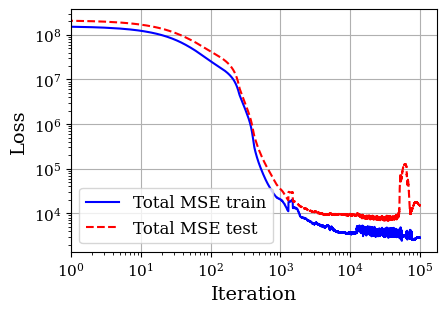

In [291]:
plt.figure(figsize=(width, height))
# plt.subplots_adjust(left=subplot_adjust_left, bottom=subplot_adjust_bottom) 

plt.plot(smooth_curve(train_total_loss_list), label='Total MSE train', color='blue', linestyle='-')
plt.plot(smooth_curve(test_total_loss_list), label='Total MSE test', color='red', linestyle='--')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)
# plt.title('Lineal homogeneous learning curve (MSE)', fontsize=title_fontsize)

plt.grid(True)
plt.legend(loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1) 

plt.show()

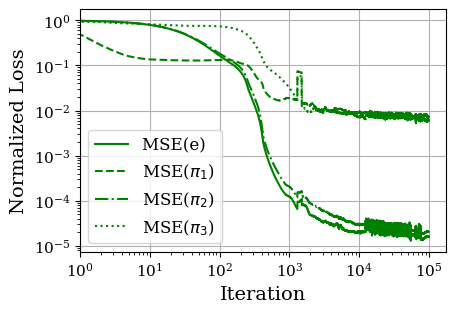

In [292]:
plt.figure(figsize=(width, height))
# plt.subplots_adjust(left=subplot_adjust_left, bottom=subplot_adjust_bottom) 

plt.plot(normalize_list(smooth_curve(train_e_loss_list)), label=r'MSE(e) ', color='green', linestyle='-')
plt.plot(normalize_list(smooth_curve(train_pi1_loss_list)), label=r'MSE($\pi_1$) ', color='green', linestyle='--')
plt.plot(normalize_list(smooth_curve(train_pi2_loss_list)), label=r'MSE($\pi_2$) ', color='green', linestyle='-.')
plt.plot(normalize_list(smooth_curve(train_pi3_loss_list)), label=r'MSE($\pi_3$) ', color='green', linestyle=':')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Normalized Loss', fontsize=label_fontsize)
# plt.title('Lineal homogeneous normalized learning curves', fontsize=s)

plt.grid(True)
plt.legend(loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1) 

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'penalties_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

In [293]:
def relative_error_stats(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    minimo = np.min(prediction_error)
    maximo = np.max(prediction_error)
    primer_cuartil = np.percentile(prediction_error, 25)
    mediana = np.percentile(prediction_error, 50)
    tercer_cuartil = np.percentile(prediction_error, 75)

    # Imprimir los resultados
    print(f"Mínimo: {minimo:.2e}")
    print(f"Primer cuartil (Q1): {primer_cuartil:.2e}")
    print(f"Mediana (Q2): {mediana:.2e}")
    print(f"Tercer cuartil (Q3): {tercer_cuartil:.2e}")
    print(f"Máximo: {maximo:.2e}")


def relative_error_return_Q(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx)/
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))
    
    tercer_cuartil = np.percentile(prediction_error, 75)

    Q_bool = prediction_error <= tercer_cuartil

    return Q_bool

In [294]:
y_pred, K_pred = model(X_val)

y_pred = TensOps(y_pred, space_dimension=2, contravariance=0, covariance=0)
K_pred = TensOps(K_pred, space_dimension=2, contravariance=0, covariance=0)

### Solution $u(x,y)$

In [295]:
u_validation = y_val.values.detach()
u_prediction = y_pred.values.detach()

relative_error_stats(u_validation, u_prediction)

Mínimo: 4.78e-04
Primer cuartil (Q1): 8.89e-04
Mediana (Q2): 1.28e-03
Tercer cuartil (Q3): 1.71e-03
Máximo: 1.52e-01


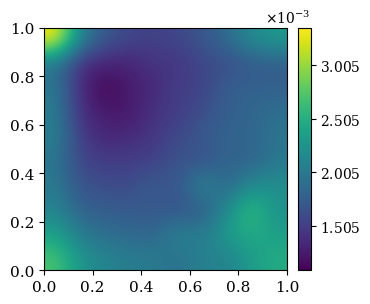

In [296]:
plt.figure(figsize=(height*1.2, height))

u_diff = torch.mean(torch.abs(u_prediction - u_validation), axis=0).squeeze()
plt.imshow(u_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.000005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'solution_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

### Solution $u_m(x, y)$

In [297]:
um_validation = zo.Mx(zo.My(y_val)).values.detach()
um_prediction = zo.Mx(zo.My(y_pred)).values.detach()

relative_error_stats(um_validation, um_prediction)

Mínimo: 3.03e-04
Primer cuartil (Q1): 7.69e-04
Mediana (Q2): 1.18e-03
Tercer cuartil (Q3): 1.67e-03
Máximo: 1.44e-01


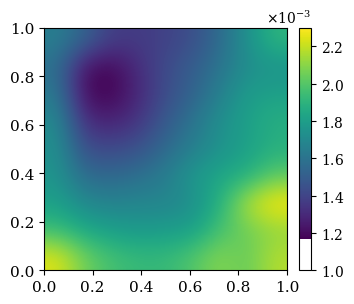

In [298]:
plt.figure(figsize=(height*1.2, height))

um_diff = torch.mean(torch.abs(um_prediction - um_validation), axis=0).squeeze()
plt.imshow(um_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.0000005)
cbar.set_ticks(new_ticks[:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

plt.show()

### Diffusivity $K(u) = u(1-u)$

In [299]:
K_validation = zo.My(zo.Mx(K_val)).values.detach()
K_prediction = K_pred.values.detach()

relative_error_stats(K_validation, K_prediction)

Mínimo: 1.39e-02
Primer cuartil (Q1): 5.42e-02
Mediana (Q2): 6.72e-02
Tercer cuartil (Q3): 7.74e-02
Máximo: 2.02e+00


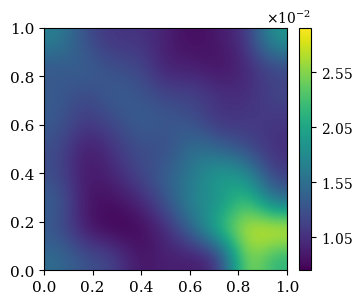

In [300]:
plt.figure(figsize=(height*1.2, height))

K_diff = torch.mean(torch.abs(K_prediction - K_validation), axis=0).squeeze()
plt.imshow(K_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.0005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'diffusivity_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

### Flux $q_x(x, y)$

In [301]:
qx_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qx_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qx_prediction = azo.scalar_product(K_pred, zo.Dx(y_pred, D)).values.detach()

relative_error_stats(qx_validation, qx_prediction)

Mínimo: 2.00e-02
Primer cuartil (Q1): 5.71e-02
Mediana (Q2): 7.10e-02
Tercer cuartil (Q3): 8.40e-02
Máximo: 3.74e+00


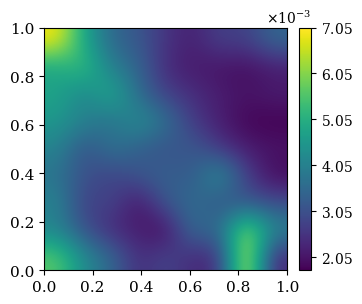

In [302]:
plt.figure(figsize=(height*1.2, height))

qx_diff = torch.mean(torch.abs(qx_prediction - qx_validation), axis=0).squeeze()
plt.imshow(qx_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.00005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'qx_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

### Flux $q_y(x, y)$

In [303]:
qy_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qy_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qy_prediction = azo.scalar_product(K_pred, zo.Dy(y_pred, D)).values.detach()

relative_error_stats(qy_validation, qy_prediction)

Mínimo: 1.87e-02
Primer cuartil (Q1): 5.63e-02
Mediana (Q2): 7.70e-02
Tercer cuartil (Q3): 8.99e-02
Máximo: 1.21e+03


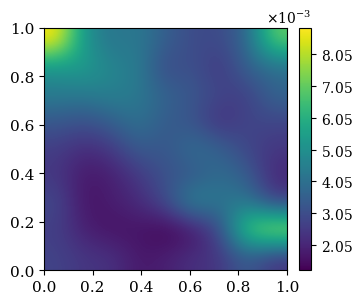

In [304]:
plt.figure(figsize=(height*1.2, height))

qy_diff = torch.mean(torch.abs(qy_prediction - qy_validation), axis=0).squeeze()
plt.imshow(qy_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.00005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'qy_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

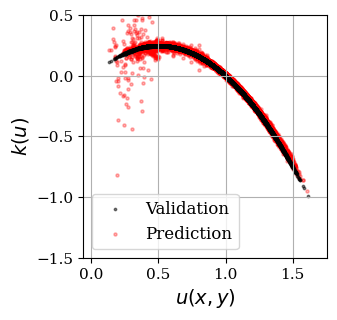

In [305]:
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

plt.figure(figsize=(height, height))
plt.scatter(um_prediction.flatten(), K_prediction.flatten(), label='Prediction', color='red', s=5, alpha=0.3)
plt.scatter(um_validation.flatten(), K_validation.flatten(), label='Validation', color='black', s=3, alpha=0.5)

plt.xlabel('$u(x, y)$', fontsize=label_fontsize)
plt.ylabel('$k(u)$', fontsize=label_fontsize)
# plt.title('Lineal homogeneous normalized learning curves', fontsize=s)

plt.grid(True)
# Obtener la leyenda actual y cambiar el orden
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]  # Cambiar el orden de las etiquetas aquí (Validation primero, Prediction segundo)
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)


min = torch.min(um_prediction.flatten()) - 0.1*(torch.max(um_prediction.flatten() - torch.min(um_prediction.flatten())))
max = torch.max(um_prediction.flatten()) + 0.1*(torch.max(um_prediction.flatten() - torch.min(um_prediction.flatten())))

plt.xlim(min, max)
plt.ylim(-1.5, 0.5)

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'ku_vs_u_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

In [306]:
er = np.sum(np.trapz(np.trapz(K_prediction.squeeze() - K_validation.squeeze(), dx=dx), dx=dy))**2/np.sum(np.trapz(np.trapz(K_validation.squeeze(), dx=dx), dx=dy))**2

print(f"er(K): {er:.2e}")


er(K): 4.03e+00


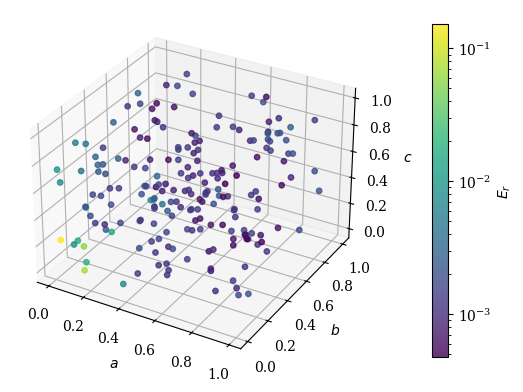

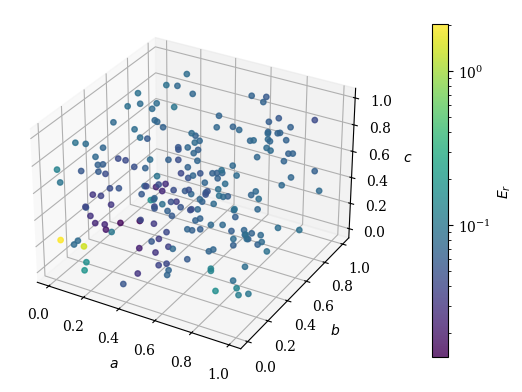

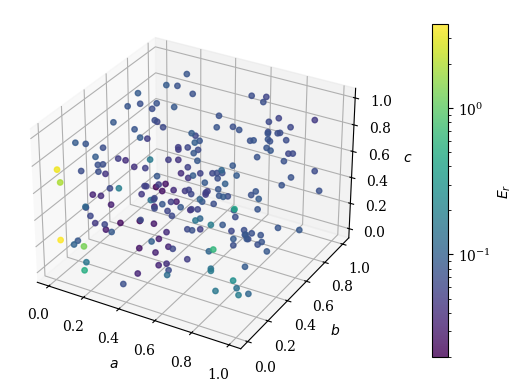

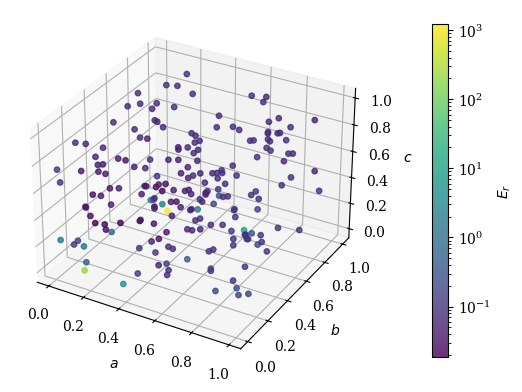

In [307]:
def relative_error(validation, prediction, dx=dx, dy=dy):
    return np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx)/
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

def calculate_error(validation_data, predicted_data):
    numerator = np.trapz(np.trapz((validation_data - predicted_data)**2))
    denominator = np.trapz(np.trapz((validation_data)**2))

    if np.all(denominator == 0):
        result = np.sqrt(numerator)
    else:
        result = np.sqrt(numerator/denominator)
    return result

E_K = relative_error(K_validation, K_prediction)
E_solution = relative_error(u_validation, u_prediction)
E_qx = relative_error(qx_validation, qx_prediction)
E_qy = relative_error(qy_validation, qy_prediction)

a = dataset['g1_val']
b = dataset['g2_val']
c = dataset['g3_val']

def plot_error(a, b, c, error, variable):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(a, b, c, c=error, cmap='viridis', s=15, alpha=0.8, norm=mcolors.LogNorm())
    cbar = plt.colorbar(sc, pad=0.12, shrink=0.9)
    cbar.set_label('$E_r$')

    ax.set_xlabel('$a$')
    ax.set_ylabel('$b$')
    ax.set_zlabel('$c$')

    # plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'{variable}_val_error_parameters_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
    plt.show()

plot_error(a=a, b=b, c=c, error=E_solution, variable='solution')
plot_error(a=a, b=b, c=c, error=E_K, variable='K')
plot_error(a=a, b=b, c=c, error=E_qx, variable='qx')
plot_error(a=a, b=b, c=c, error=E_qy, variable='qy')